# Methods - Demonstration
<hr style="clear:both">
This notebook is used to showcase how the methods used in our project work on real examples. For our project, which is divided into 3 parts, we use the following methods / algorithms. 

### Part 1
- **Sentiment Analysis**: We run a sentiment analysis model to determine if the reviews of the movies are positive or negative. The model we decided to use is [distilbert](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english). This allows us to quantify the movie critics which will be useful in the creation of our success metric.
- **Success Metric Creation**: We create a "Success" metric that is based on the combination of different measures of movies success, such as: Box office revenue, ratings, reviews and popularity.

### Part 3
- **Time Series Prediction**: We predict future trends on some pandas timeseries created using the success metric. The generated series are closer to impact series as we apply a given change to the derivative of this impact series. The magnitude of the change in the derivative being proportional to the success metric. Using these impact series, we can make some predictions as to what the next dominant genres of the movie industry are going to be. 

**Project Mentor:** [Shuo Wen](http://personnes.epfl.ch/shuo.wen) ([Email](shuo.wen@epfl.ch)),
**Authors:** Mahmoud Dokmak, Matthieu Borello, Léo Brunneau, Loïc Domingos, Bastien Armstrong

<hr style="clear:both">

In [2]:
# Imports needed to run the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

from src.models.PolynomialRegression import polynomial_regression
from src.models.ARIMA import arima
from src.utils.print_prediction import plot_results
from src.utils.results_utils import success

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


### Sentiment analysis

In [7]:
# Loading a Pre-Trained Model from HuggingFace Hub
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Creating a Function to Run the Application
def run_classification(text):
    result = classifier(text)
    return result

# Running the Application
input_text = "I love using HuggingFace models for NLP tasks!"
pos_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {pos_result}")

Input: I love using HuggingFace models for NLP tasks!
Classification: [{'label': 'POSITIVE', 'score': 0.9959064722061157}]


Thus the score is positive and the model is quite confident in himself! Yay, that's exactly what we expected 

In [8]:
input_text = "I hate handing in my assignments on the last day!"
neg_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neg_result}")

Input: I hate handing in my assignments on the last day!
Classification: [{'label': 'NEGATIVE', 'score': 0.9981616139411926}]


Here, the sentiment is negative which is also what we expected. Great!

In [9]:
input_text = "The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved"
neut_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neut_result}")

Input: The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved
Classification: [{'label': 'POSITIVE', 'score': 0.9808715581893921}]


Once again on the mark !
We will thus implement this for our reviews.

### Success metric creation
The success metric is based on a combination of different measures. We took into account its popularity (a metric taken from [Full TMDB Movies Dataset 2024](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data)), the box office revenue, people's ratings and the people reviews with sentiment analysis. We computed the success metric by assigning the correct weights (the ones we think were the most appropriate) to each of these measures. For more information, see the `results.ipynb` notebook. Let's see how it works on a simple example:

In [18]:
# Our metric requires the normalization of the data to be computed correctly
simple_movie_df = pd.DataFrame({
    "name": ["The Lion King", "The Dark Knight", "The Chorus"],
    "popularity": [1, 1, 0.795474],
    "revenue": [0.222263, 0.161508, 0.009824],
    "sentiment_analysis": [0.887029, 0.767742, 0.850877],
    "rating": [0.777832, 0.830994, 0.762319]
}) 
success_df = success(simple_movie_df, 'popularity', 'revenue', 'sentiment_analysis', 'rating')
success_df

,name,popularity,revenue,sentiment_analysis,rating,success_score,success_metric_scaled
0,The Lion King,1.000000,0.222263,0.887029,0.777832,16.772687,5.000000
1,The Dark Knight,1.000000,0.161508,0.767742,0.830994,16.088272,4.122492
2,The Chorus,0.795474,0.009824,0.850877,0.762319,12.872920,0.000000


It outputs the success score between 0 and 26 that we scale between 0 and 5 to have a result that is easier to interpret.

### Time series prediction

The first step to predict the future trends in timeseries is to actually create these timeseries using our success metric. We wanted to create series that had a meaningful sense and not just an aggregation of the success metric. Thus, we decided to follow a set of rules to create them.
- **Causality**: We want our series to respect causality. The success of a movie can't have an impact before it's release. This means we couldn't simply use techniques like kernel regression with a gaussian. There are probably already existing ML methods that exist having a similar solution to what we have implemented. However we haven't heard of them. The solution we ended up on is to apply a positive value to the first derivative of the series we create (so we create the derivative first and then integrate it to get the impact series). We then apply a negative value to the first derivative that represents the gradual loss of impact of the movie on the industry (Movies can get forgotten). Here is an example of how we apply the positive gain.

> `linear_end_time = event_time + pd.Timedelta(days = linear_duration)`
> `if linear_end_time > first_derivative_series.index[-1]:`
>   `linear_end_time = first_derivative_series.index[-1]`
>
> `linear_range = np.linspace(0, spike_value, (linear_end_time - event_time).days + 1)`
> `first_derivative_series.loc[event_time:linear_end_time] += linear_range`

- **Successful movie == Large Impact**: Successful movies will have a greater impact then less successful movies on their respective genres. We even want the average movies to have a nearly negligeable impact on the industry. To achieve this, we applied a shifted sigmoid to the success metric of the movies. 

> `spike_value = 10 * (1 / (1 + np.exp(-0.5 * (spike_value - (mean_success_genre + 2)))))`

- **Memorable movies**: The impact of successful movies on a genre will last longer. We achieve this by extanding the duration of the positive and negative gain depending on the value of the success.

> `base_duration = 30`
> `linear_duration = int(base_duration * (1 + spike_value*4))`

- **No negative impact**: We did not want genres to have negative impact. We want to impact to always be positive or zero. To achieve this, we make sure that the total area under the curve to be zero. This means that the total change over time of the function will be 0. We get this change in impact by having first a positive growth and then a negative growth which creates this impact. We also make sur that all negative values (probabaly due to rounding errors) are equal to zero. 

> `impact_series[impact_series < 0] = 0`

Now that all this is said, here is a simple demonstration of how this can work.

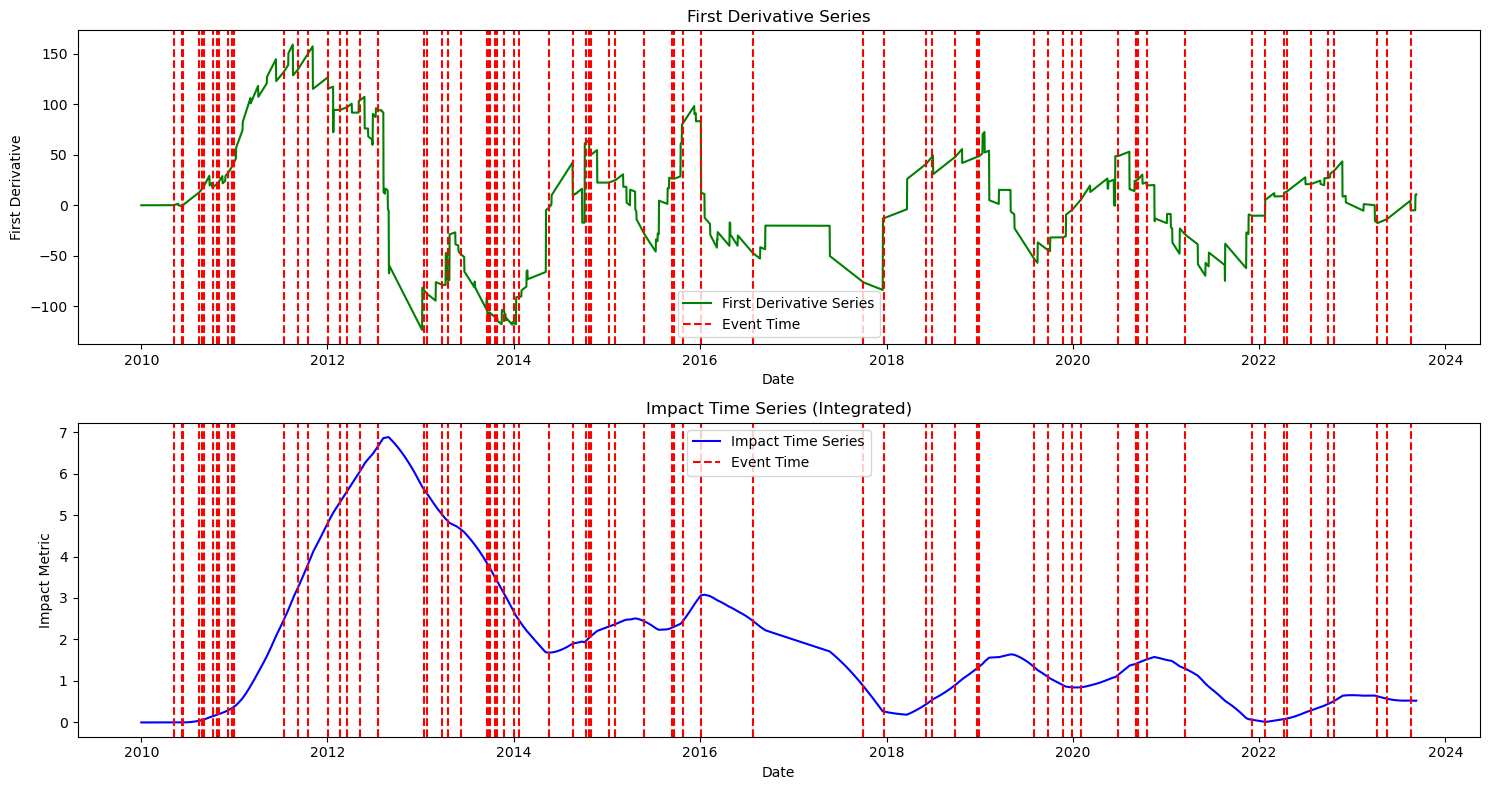

In [9]:
# This example is a simplified version of the Impact.py function that implements all the features we talked about
num_events = 75
base_duration = 5

time_index = pd.date_range(start='2010-01-01', periods=5000, freq='D')

first_derivative_series = pd.Series(0.0, index=time_index)

event_times = np.random.choice(range(len(first_derivative_series)), size=num_events, replace=False)
event_times.sort() 

for event_time in event_times:
    spike_value = np.random.exponential(20) 
    linear_duration = int(base_duration * (1 + spike_value*2))

    # We first add a linear growth (positive) 
    linear_end = min(event_time + linear_duration, len(first_derivative_series))
    linear_range = np.linspace(0, spike_value, linear_end - event_time)
    first_derivative_series.iloc[event_time:linear_end] += linear_range

    # Decay, the movie starts to lose the interest of the public (Wanted to do exponential but did not have the time)
    decay_end = min(event_time + 2*linear_duration, len(first_derivative_series))
    decay_range = -np.linspace(0, spike_value, decay_end - linear_end)
    first_derivative_series.iloc[linear_end:decay_end] += decay_range

impact_series = first_derivative_series.cumsum()
impact_series = impact_series / 10000 
impact_series[impact_series < 0] = 0 


plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(first_derivative_series, label="First Derivative Series", color="green")
for event_time in event_times:
    plt.axvline(time_index[event_time], color='red', linestyle='--', label="Event Time" if 'Event Time' not in plt.gca().get_legend_handles_labels()[1] else None)
plt.title("First Derivative Series")
plt.xlabel("Date")
plt.ylabel("First Derivative")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(impact_series, label="Impact Time Series", color="blue")
for event_time in event_times:
    plt.axvline(time_index[event_time], color='red', linestyle='--', label="Event Time" if 'Event Time' not in plt.gca().get_legend_handles_labels()[1] else None)
plt.title("Impact Time Series (Integrated)")
plt.xlabel("Date")
plt.ylabel("Impact Metric")
plt.legend()

plt.tight_layout()
plt.show()

As we can see from this simple example, there are a couple of factors which could play into a given genre's impact:
- A large number of medium success movies will have a large impact. 
- Few very successful movies will have a large impact. 
- Unsuccessful movies will have basically no impact on a given genre, even if there are a lot.

We are going to compare the performance of two different models. The first is a "simple" polynomial regression and the second is ARIMA or Autoregressive integrated moving average. ARIMA is a model which is often used in economics to make predictions of the market. 

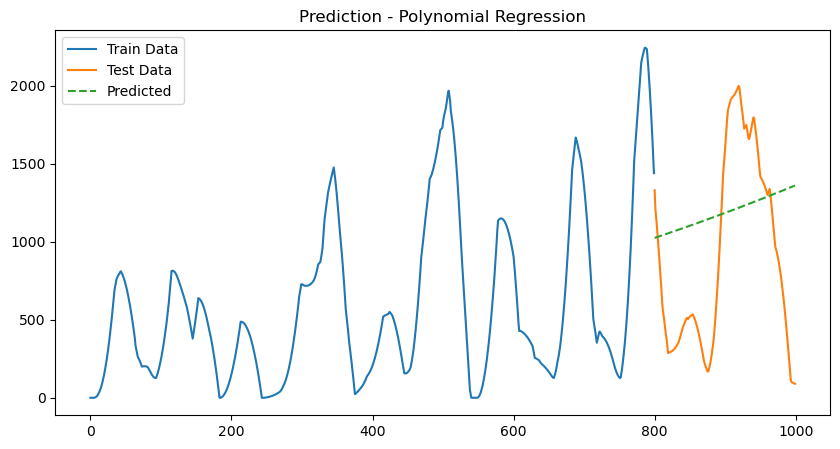

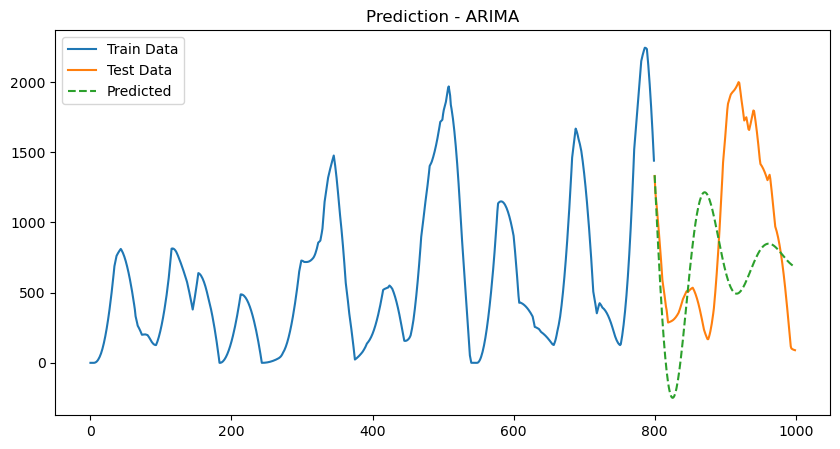

In [11]:
np.random.seed(0)
n = 1000
train, test = impact_series[:800], impact_series[800:]

poly_predictions = polynomial_regression(train, degree=2, n_forecast=len(test + 1000))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

# p is the number of previous points used to make the prediction
# d is the differentiating order to eliminate trends
# q is the moving average window
order = (400, 2, 20)  # (p,d,q)

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test+ 1000))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")

One important thing to note is that the ARIMA model seem to be performing worse when the number of samples in the timeseries is smaller (See below). This could be an issue for genres that have started releasing movies recently. However, we might be able to fix this issue with better initial choices of parameters for the model. 

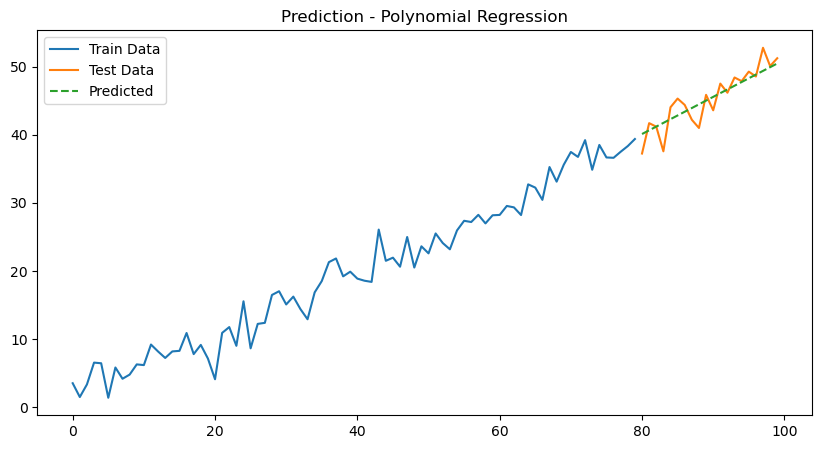

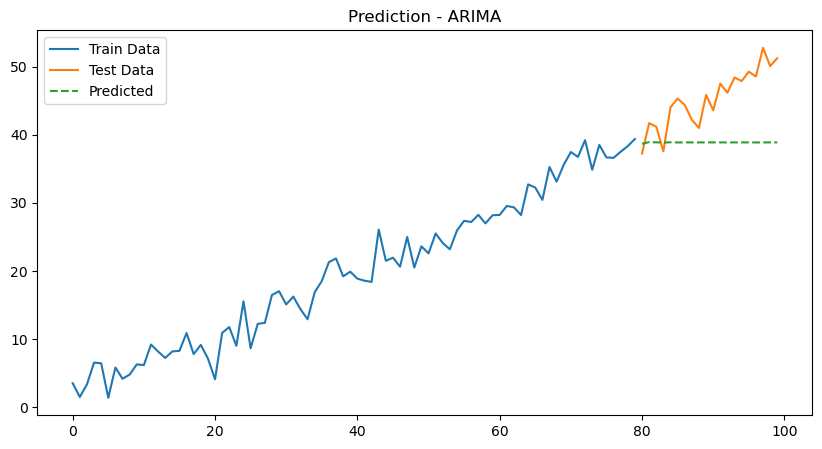

In [5]:
np.random.seed(0)
n = 100
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = time_series[:80], time_series[80:]

poly_predictions = polynomial_regression(train, degree=3, n_forecast=len(test))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

order = (20, 1, 20) 

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")